- Name: Sai Kumar Reddy Peddholla
- USC ID: 5978435849
- GitHub: peddholl

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import Sequential, layers, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
!unzip '/content/drive/MyDrive/data.zip'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('/content/data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [8]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('/content/drive/MyDrive/train_source_images.txt')
validate_ids = load_text_ids('/content/drive/MyDrive/val_source_images.txt')
test_ids = load_text_ids('/content/drive/MyDrive/test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [9]:
import random
import tensorflow as tf
from PIL import Image

def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')


        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

### (c) Training CNN + MLP
### i. To perform empirical regularization, crop, randomly zoom, rotate, flip, con-trast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [30]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=2)
    return image, label

def modify_image_shape(image, label):
    image.set_shape((None, 299, 299, 3))
    label.set_shape([None, 2])
    return image, label

def augment_image(image, label):
    return data_aug(image, training=True), label

tf_dataset_train = tf_dataset_train.map(one_hot_encode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.map(one_hot_encode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.map(one_hot_encode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
])

tf_dataset_train_modified = tf_dataset_train.map(modify_image_shape, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train_augmented = tf_dataset_train_modified.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val_reshaped = tf_dataset_val.map(modify_image_shape, num_parallel_calls=tf.data.experimental.AUTOTUNE)

### ii. Train a three-layer CNN followed by a dense layer on the data. Choose the size of the kernels and depth of the layers and the number of neurons in the dense layer (MLP) on your own. Use ReLU’s in all of the layers. Use the softmax function, batch normalization 3 and a dropout rate of 30%, L2 regularization, as well as ADAM optimizer. Use cross entropy loss. Train for at least 20 epochs and perform early stopping using the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

Epoch 1/25
442/442 [==============================] - 490s 1s/step - loss: 6.0632 - accuracy: 0.8037 - val_loss: 2.9069 - val_accuracy: 0.7533
Epoch 2/25
442/442 [==============================] - 477s 1s/step - loss: 1.4632 - accuracy: 0.8732 - val_loss: 2.1302 - val_accuracy: 0.8866
Epoch 3/25
442/442 [==============================] - 471s 1s/step - loss: 1.1685 - accuracy: 0.8785 - val_loss: 23.2234 - val_accuracy: 0.5623
Epoch 4/25
442/442 [==============================] - 463s 1s/step - loss: 3.9986 - accuracy: 0.7967 - val_loss: 4.1000 - val_accuracy: 0.3273
Epoch 5/25
442/442 [==============================] - 484s 1s/step - loss: 1.3813 - accuracy: 0.8678 - val_loss: 1.4062 - val_accuracy: 0.8086
Epoch 6/25
442/442 [==============================] - 473s 1s/step - loss: 0.8382 - accuracy: 0.9068 - val_loss: 1.0748 - val_accuracy: 0.8351
Epoch 7/25
442/442 [==============================] - 470s 1s/step - loss: 0.5761 - accuracy: 0.9191 - val_loss: 0.7923 - val_accuracy: 0.903

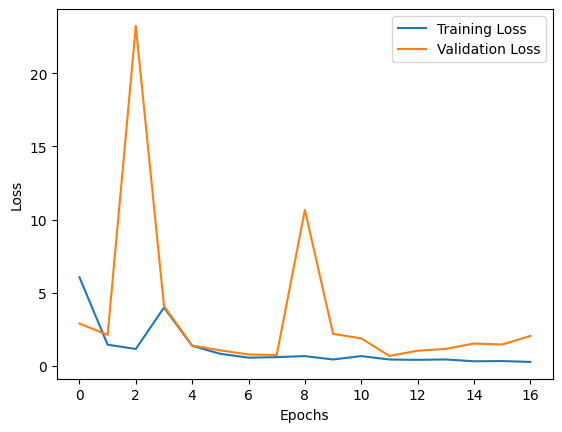

In [36]:
height = 299
width = 299
channels = 3

model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(tf_dataset_train_augmented, epochs=25, validation_data=tf_dataset_val_reshaped, callbacks=[early_stopping_callback])

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### iii. Report Precision, Recall, and F1 score for your model.

In [37]:
model.evaluate(tf_dataset_val_reshaped)

247/247 [==============================] - 42s 170ms/step - loss: 0.6909 - accuracy: 0.9407


[0.6909410357475281, 0.9406768679618835]

In [38]:
tf_dataset_test_reshaped = tf_dataset_test.map(modify_shape, num_parallel_calls=tf.data.experimental.AUTOTUNE)
model.evaluate(tf_dataset_test_reshaped)

442/442 [==============================] - 73s 164ms/step - loss: 0.8965 - accuracy: 0.7618


[0.896477460861206, 0.761810302734375]

In [41]:
y_true_labels = []
y_pred_labels = []

for images, labels in tf_dataset_test_reshaped:
    predictions = model.predict(images)

    y_pred_labels.extend(np.argmax(predictions, axis=1).tolist())
    y_true_labels.extend(np.argmax(labels, axis=1).tolist())

classification_report_output = metrics.classification_report(y_true_labels, y_pred_labels)
print(classification_report_output)

1/1 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.96      0.67      0.78      9187
           1       0.60      0.94      0.73      4932

    accuracy                           0.76     14119
   macro avg       0.78      0.80      0.76     14119
weighted avg       0.83      0.76      0.77     14119

